In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Conditional VAE Class
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.fc1 = nn.Linear(28*28 + num_classes, 256)
        self.fc21 = nn.Linear(256, latent_dim)
        self.fc22 = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim + num_classes, 256)
        self.fc4 = nn.Linear(256, 28*28)
        self.num_classes = num_classes

    def encode(self, x, labels):
      labels_onehot = torch.eye(self.num_classes, device=device)[labels]
      x = torch.cat([x.view(-1, 28*28), labels_onehot], dim=1)
      h1 = torch.relu(self.fc1(x))
      return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
      labels_onehot = torch.eye(self.num_classes, device=device)[labels]
      z = torch.cat([z, labels_onehot], dim=1)
      h3 = torch.relu(self.fc3(z))
      return torch.sigmoid(self.fc4(h3))

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar

model = ConditionalVAE().to(device)

# Loss + Optimizer
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
epochs = 50
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1} Loss: {train_loss / len(train_loader.dataset):.4f}')

print("✅ Training Done.")

# Save model
torch.save(model.state_dict(), 'cvae_mnist.pth')
print("✅ Model saved.")

# Generate Digits Function
def generate_digit_samples(digit, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 20).to(device)
        labels = torch.tensor([digit]*num_samples).to(device)
        samples = model.decode(z, labels).cpu()
        samples = samples.view(num_samples, 28, 28)

        plt.figure(figsize=(10,2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(samples[i], cmap='gray')
            plt.axis('off')
        plt.show()

# Example: Generate digit '7'



Using: cuda
Epoch 1 Loss: 173.3291
Epoch 2 Loss: 124.2805
Epoch 3 Loss: 115.9171
Epoch 4 Loss: 112.0616
Epoch 5 Loss: 109.7540
Epoch 6 Loss: 108.0663
Epoch 7 Loss: 106.7849
Epoch 8 Loss: 105.8509
Epoch 9 Loss: 105.1096
Epoch 10 Loss: 104.4987
Epoch 11 Loss: 103.9655
Epoch 12 Loss: 103.5923
Epoch 13 Loss: 103.1597
Epoch 14 Loss: 102.8014
Epoch 15 Loss: 102.5341
Epoch 16 Loss: 102.2639
Epoch 17 Loss: 101.9850
Epoch 18 Loss: 101.8408
Epoch 19 Loss: 101.6117
Epoch 20 Loss: 101.4237
Epoch 21 Loss: 101.2577
Epoch 22 Loss: 101.1118
Epoch 23 Loss: 100.9245
Epoch 24 Loss: 100.8093
Epoch 25 Loss: 100.6897
Epoch 26 Loss: 100.6276
Epoch 27 Loss: 100.4820
Epoch 28 Loss: 100.3836
Epoch 29 Loss: 100.2509
Epoch 30 Loss: 100.1752
Epoch 31 Loss: 100.0351
Epoch 32 Loss: 99.9891
Epoch 33 Loss: 99.9061
Epoch 34 Loss: 99.8403
Epoch 35 Loss: 99.7775
Epoch 36 Loss: 99.6960
Epoch 37 Loss: 99.5904
Epoch 38 Loss: 99.5112
Epoch 39 Loss: 99.4947
Epoch 40 Loss: 99.3713
Epoch 41 Loss: 99.3030
Epoch 42 Loss: 99.2997


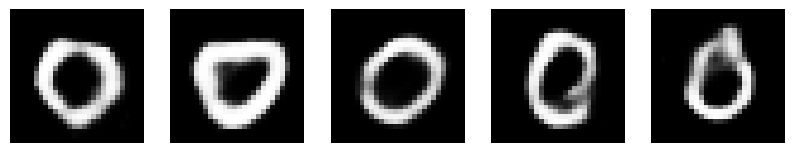

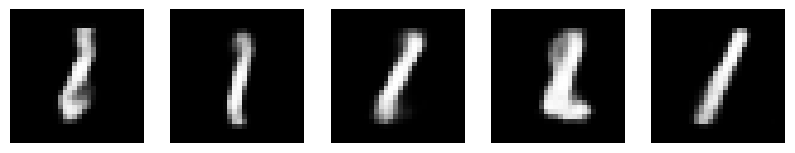

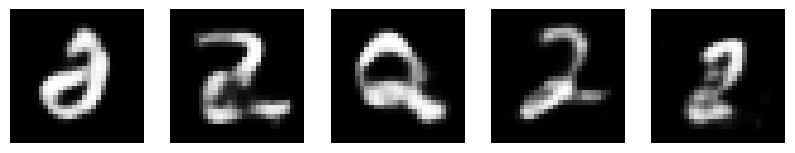

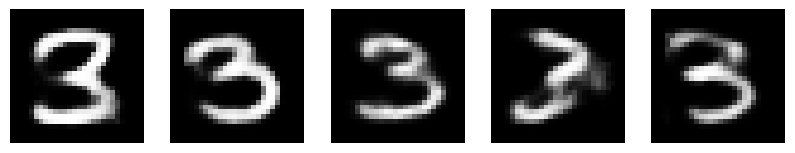

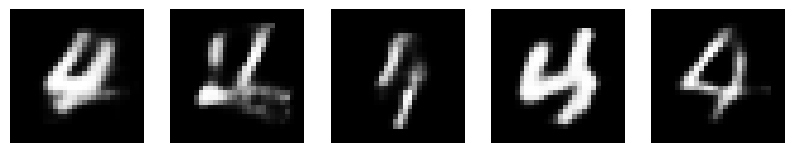

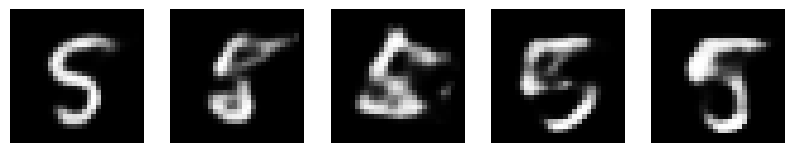

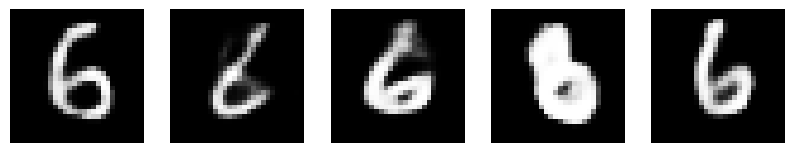

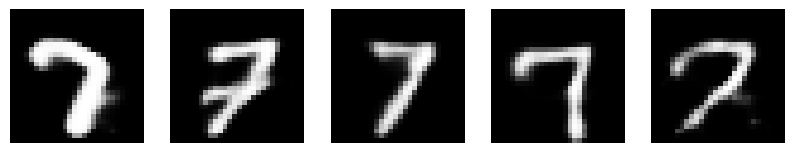

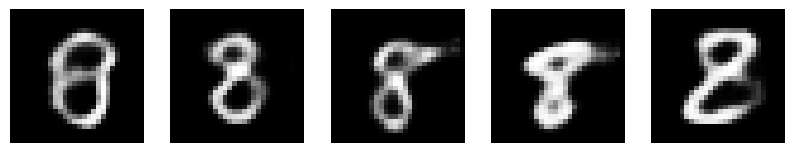

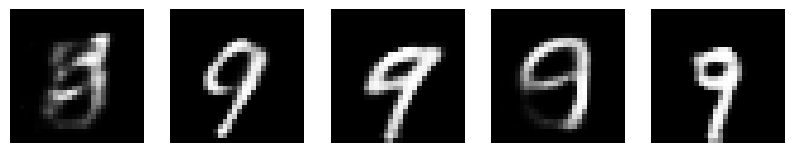

In [ ]:
for i in range(10):
  generate_digit_samples(i)

In [ ]:
torch.save(model.state_dict(), 'cvae_mnist_100.pth')
print("✅ Model saved.")

✅ Model saved.
